# **Personality type prediction using Myers-Briggs Type Indicator(MBTI) from social media post**

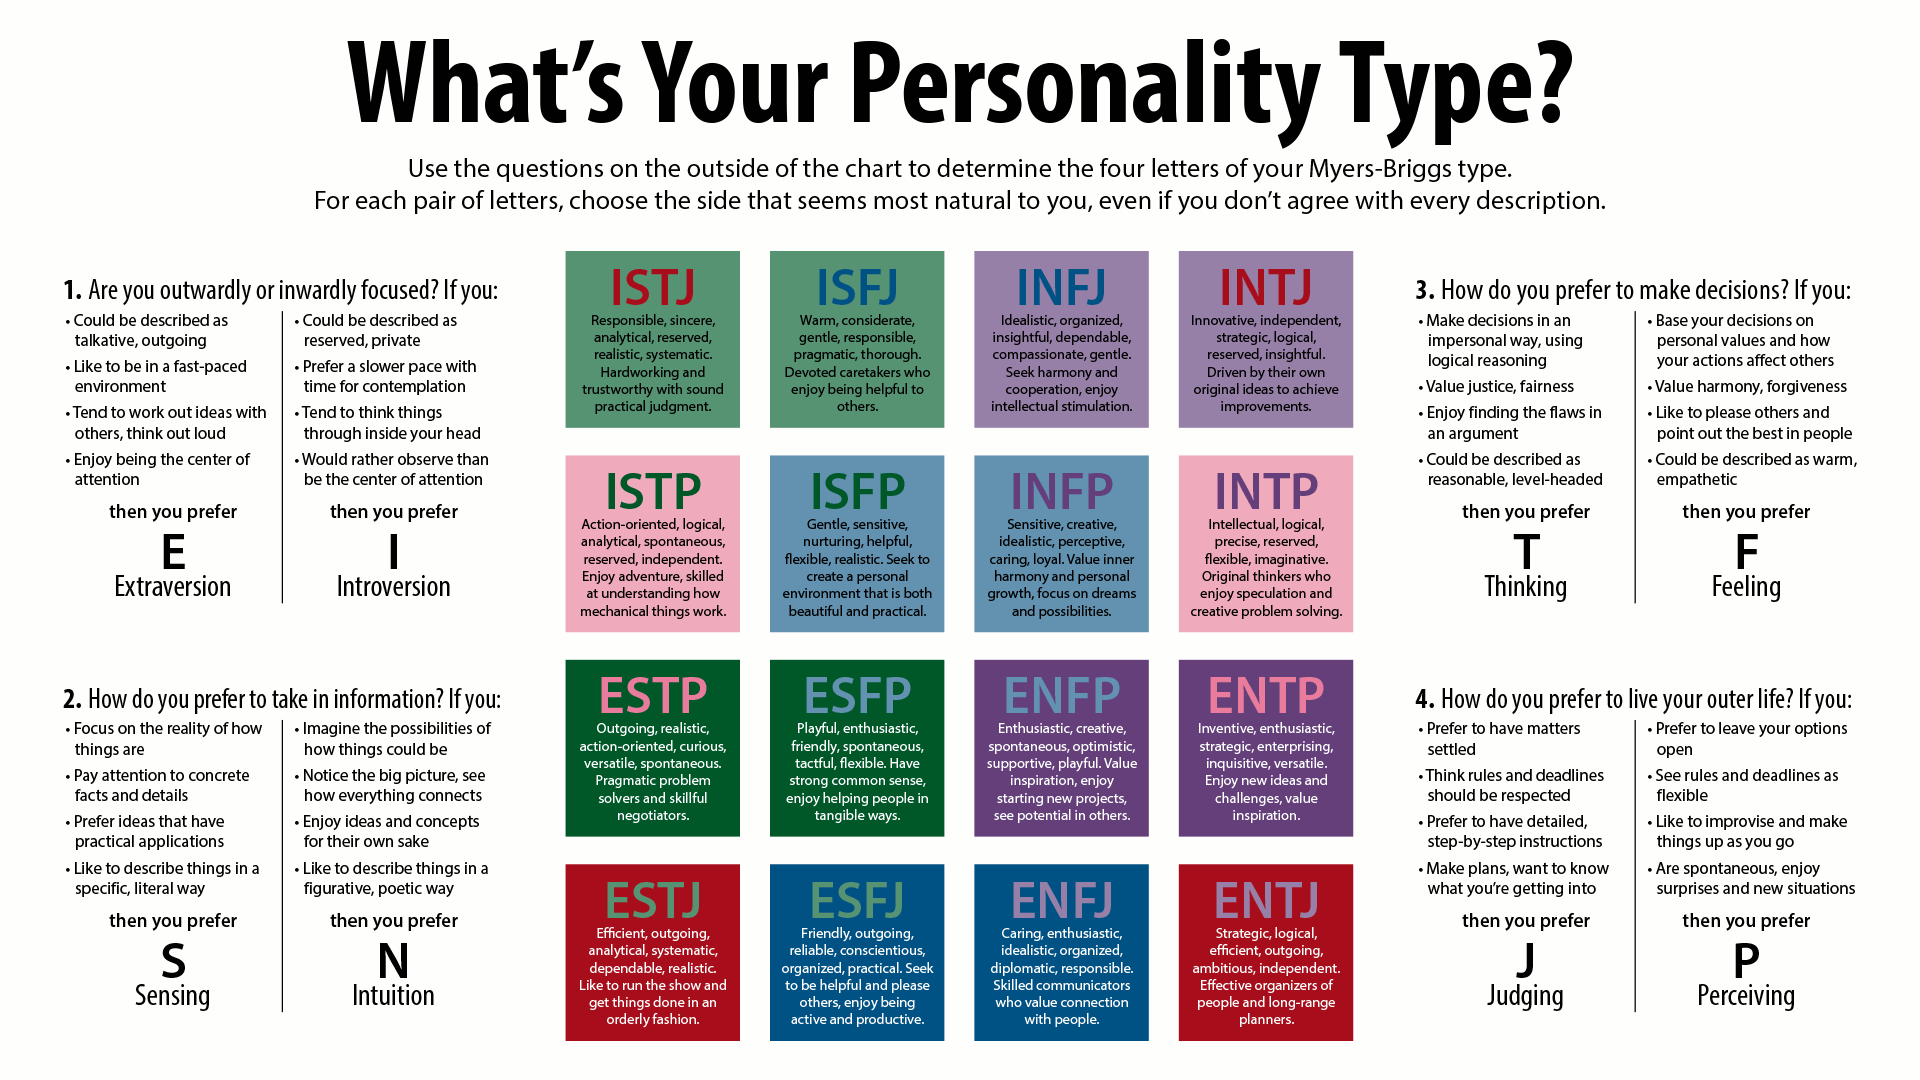

In [ ]:
from IPython.display import Image
Image(filename='Personality type using MBTI.png') 

In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official==2.4.0
!pip install contractions

     |████████████████████████████████| 4.9 MB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 3.7 MB/s 
     |████████████████████████████████| 596 kB 7.7 MB/s 
     |████████████████████████████████| 99 kB 4.4 MB/s 
     |████████████████████████████████| 1.2 MB 33.8 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 352 kB 40.9 MB/s 
     |████████████████████████████████| 1.1 MB 37.4 MB/s 
     |████████████████████████████████| 213 kB 43.1 MB/s 
     |████████████████████████████████| 47.6 MB 2.4 MB/s 
     |████████████████████████████████| 284 kB 5.3 MB/s 
     |████████████████████████████████| 321 kB 30.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85447 sha256=c3ae983d5370ddfe4b116b9f74eb9808d5f5c506b41ba0a972373cec8f1a28ca
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasi

### **Importing the required libraries**

In [2]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from keras.utils import np_utils

tf.get_logger().setLevel('ERROR')

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**MBTI PersonalityCafe Dataset**

The first dataset used is publicly available in Kaggle. This data has been collected from the PersonalityCafe forum. The MBTI dataset contains 8675 rows of data, wher each row is a person’s MBTI personality type, a combination of four labels and a section of fifty posts obtained from the individual’s social media. Each post has been separated by three pipe characters.

## **Exploring the Data**

### **1. Loading the MBTI PersonalityCafe dataset**

In [ ]:
import pandas as pd

data = pd.read_csv("mbti.csv")
print(data)

      type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

[8675 rows x 2 columns]


### **1.1.Analysing the dataset**

In [ ]:
print("The shape of the data is : ",data.shape)

The shape of the data is :  (8675, 2)


Checking the data types of each column in the dataset.

In [ ]:
print(data.dtypes)

type     object
posts    object
dtype: object


Checking for any null values.

In [ ]:
data.isnull().any()

type     False
posts    False
dtype: bool

describe() method gives the basic summarisation of the DataFrame.

In [ ]:
data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'I honestly think PerC's debate/current events...
freq,1832,1


Finding the unique values from the column 'type'. This displays the 16 different personality types. 

In [ ]:
unique_types = data['type'].unique()
unique_types

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

### **1.3.Data visualization for number of posts for each type.**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


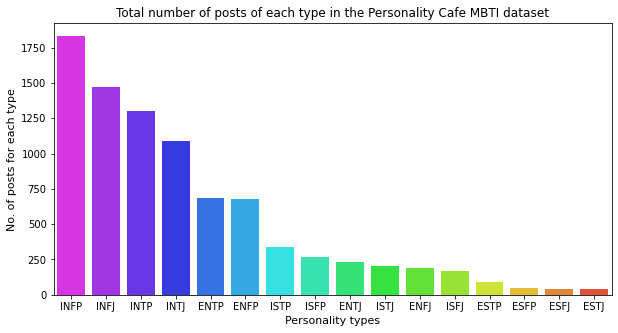

In [ ]:
post_count = data['type'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(post_count.index,post_count.values,alpha=0.9,palette='gist_rainbow_r')
plt.xlabel('Personality types', fontsize=11)
plt.ylabel('No. of posts for each type', fontsize=11)
plt.title('Total number of posts of each type in the Personality Cafe MBTI dataset')
plt.show()

The above visualization shows the total number of posts of each type in the dataset. This shows that the data is heavily imbalanced. The personality type INFP has the most number of comments in the dataset. Because of this imbalanced dataset the model may tend to favor the prediction of the majority class and it may ignore the minority class. 

### **1.4Analysing the posts**

In [ ]:
data.posts.values[0]

"'Also, sometimes I find myself very dependent on music. It can completely alter my mood, or enhance it greatly, for that matter. Not sure if that's healthy, but I don't think I'm the only one.|||I find myself harmonizing a lot. But I feel different than those around me in the sense that I'm much more accustomed to listening to an album all the way through as opposed to listening to a bunch...|||i've fallen into a habit of wanting to be alone when I'm with people and wanting to be with people when I'm alone. I've been on two trips this summer with friends, and both times after about four...|||Drama kid!|||Things really are just far too complicated, huh? I wish I just knew what I wanted/that I could make up my mind. If I had known six months ago things would still be like this, I wonder if I would have...|||I always have on bracelets (usually the same ones everyday) and a cross necklace. Every accessory I wear has to mean something to me. I don't wear bracelets to look pretty, each of t

In [ ]:
def extract(posts,new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
data.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(data))
print("Number of posts", len(posts))
print("5 posts from start are:")
posts[0:20]

Number of users 8675
Number of posts 422845
5 posts from start are:


[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.'),
 ('INFJ', 'May the PerC Experience immerse you.'),
 ('INFJ',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206'),
 ('INFJ',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as..."),
 ('INFJ',
  '84389  84390  http://wallpaperpassion.com/upload/23700/

### **Checking whether the personality type words (eg. 'INTP', 'ESFJ'...) are present in the Posts.**

In [ ]:
personality_words = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ', 'MBTI']
a = data['posts'].apply(lambda x: any([k in x for k in personality_words])).sum()
print("There are {num} instances of 'Personality type words'. ".format(num=a))
print('\n')
data['posts'].apply(lambda x: any([k in x for k in personality_words]))


There are 8186 instances of 'Personality type words'. 




0       True
1       True
2       True
3       True
4       True
        ... 
8670    True
8671    True
8672    True
8673    True
8674    True
Name: posts, Length: 8675, dtype: bool

The output above shows that the personality type words are present in the posts. It is importatnt to remove these words from the posts to get valid model accuracy estimation for unseen data. 

### **2.Preprocessing**

1. Removing URL’s: The comments contain number of websites, since the model is to be generalized to English language, so the links to the websites are removed. 

2.	Removing punctuation and special characters: Using Regular expression, punctuation and special characters are removed that appear rarely in the sentences to improve the performance of the model. 

3.	Removing numbers: numbers are removed as it doesn’t provide any useful information for the text. 

4. Expanding a contraction in the sentence such as the use of ‘you’re’ become ‘you are’.


5.	Filtering non-words: Words without meaning or no occurrence in any text corpus or dictionary are removed using NLTK’s word punkt tokenizer. 

6. Converting each sentence into lower case. 

7.	Removing stop-words: removing the stop-words (e.g., commonly used filter words like ‘a’, ‘the’, ‘is’, etc.,) from the text using python’s NLTK text processing library and giving more focus to the important words. 

8.	Removing Personality type words: Since the three datasets used in this project comes from the websites intended for explicit discussion of MBTI type personality, it is important to remove the personality types from the posts to get valid model accuracy estimation for unseen data.

9.	Removing words with length less than 3. 

10.	Lemmatisation: Lemmatisation is done by using WordNetLemmatizer that reduces words to its root word. Lemmatisation is done because when reduced to root word it produces a dictionary meaning word (e.g., words ‘played’, ‘plays’, ‘playing’ all become ‘play’). This inflected forms, can be analyzed as a same word carry one shared meaning and it provides more accuracy.

In [47]:
import re
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
import contractions

def preprocessing(posts):
         
        posts = re.sub('\|\|\|', ' ', posts)
        posts = re.sub('https?://\S+|www\.\S+', '', posts)
        posts = contractions.fix(posts)
        posts = posts.lower()
        posts = re.sub('[0-9]+', '', posts)
        posts = (re.sub(' +', ' ',(posts.replace('\\n','')))).strip()
        posts = re.sub(r'[\.+~*]', ".",posts)
        
        #Remove multiple fullstops
        #posts = re.sub(r'[^\w\s]','',posts)

        #Remove Non-words
        posts = re.sub(r'[^a-zA-Z\s]','',posts)

        #Remove multiple letter repeating words
        #posts = re.sub(r'([a-z])\1{2,}[\s|\w]*','',posts)

        #filtering non-words
        #posts = " ".join(word for word in nltk.wordpunct_tokenize(posts) if word.lower() in words or not word.isalpha())

        stop_words = stopwords.words("english")
        personality_words = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp','isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj', 'mbti']
        stop_words.extend(personality_words)
        posts =  ' '.join([w for w in posts.split() if w not in stop_words])

        posts = ' '.join(word for word in posts.split() if len(word)>3)

        lemmatizer = WordNetLemmatizer()
        word_tokens = nltk.word_tokenize(posts)
        posts = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])        
                
        return posts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print("Posts before Preprocessing : ")
print("\n")
print(data['posts'][0])
print("\n")
data['cleaned_posts'] = data['posts'].apply(preprocessing)
print("Posts after Preprocessing : ")
print("\n")
data['cleaned_posts'].values[0]
                        

Posts before Preprocessing : 


'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/20

'moment sportscenter play prank lifechanging experience life repeat today perc experience immerse last thing friend posted facebook committing suicide next rest peace hello sorry hear distress natural relationship perfection time every moment existence figure hard time time growth welcome stuff game match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe edible healthier alternative basically come three item determined type whichever type want would likely given type cognitive function whatnot left thing moderation sims indeed video game good note good somewhat subjective completely promoting death given dear favorite video game growing current favorite video game cool appears late someone everyone wait thought confidence good thing cherish time solitude revel within inner world whereas time would workin enjoy time worry people always around lady complimentary personalitywell main social outlet xbox live conversation even verbally fat

In [ ]:
data

,type,posts,cleaned_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank lifechanging ex...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming boring position oft...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation esoteric gabbing nat...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp always think cat doms reason especially w...
8671,ENFP,'So...if this thread already exists someplace ...,soif thread already exists someplace else heck...
8672,INTP,'So many questions when i do these things. I ...,many question thing would take purple pill pic...
8673,INFP,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly m...


Peridicting MBTI type personality by using binary classifiaction. The aim is to build four binary classifiers that classifies each of the individual's post as MBTI traits. In order to achieve this, the MBTI PersonalityCafe dataset is splitted into four binary datasets.

Four binary datasets were created by splitting the personality traits from the column 'types' and concatenating each type with the corresponding posts.



*   
First dataset with Introvert/Extrovert type.
*   Second dataset with Sensing/INtuition type.
*   Third dataset with Feeling/Thinking type.

*   Fourth dataset with Judjing/Perceiving type.


In [ ]:
split_types = data_mbti['type'].str.split('',expand=True)
split_types = split_types.drop(split_types.columns[[0, 5]], axis=1)
split_types

,1,2,3,4
0,I,N,F,J
1,E,N,T,P
2,I,N,T,P
3,I,N,T,J
4,E,N,T,J
...,...,...,...,...
8670,I,S,F,P
8671,E,N,F,P
8672,I,N,T,P
8673,I,N,F,P


In [ ]:
data = [split_types[1], data_mbti["posts"]]
headers = ["types","posts"]

binary_df1 = pd.concat(data, axis=1, keys=headers)

data = [split_types[2], data_mbti["posts"]]
headers = ["types", "posts"]

binary_df2 = pd.concat(data, axis=1, keys=headers)

data = [split_types[3], data_mbti["posts"]]
headers = ["types", "posts"]

binary_df3 = pd.concat(data, axis=1, keys=headers)

data = [split_types[4], data_mbti["posts"]]
headers = ["types", "posts"]

binary_df4 = pd.concat(data, axis=1, keys=headers)

print(binary_df1)
print(binary_df2)
print(binary_df3)
print(binary_df4)

     types                                              posts
0        I  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1        E  'I'm finding the lack of me in these posts ver...
2        I  'Good one  _____   https://www.youtube.com/wat...
3        I  'Dear INTP,   I enjoyed our conversation the o...
4        E  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670     I  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671     E  'So...if this thread already exists someplace ...
8672     I  'So many questions when i do these things.  I ...
8673     I  'I am very conflicted right now when it comes ...
8674     I  'It has been too long since I have been on per...

[8675 rows x 2 columns]
     types                                              posts
0        N  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1        N  'I'm finding the lack of me in these posts ver...
2        N  'Good one  _____   https://www.yo

The four binary datasets were created and the dataframes are converted to csv files and downloaded the files for future use.

In [ ]:
from google.colab import files

binary_df1.to_csv("MBTI_BinaryLabels_I_E.csv", index= False)
binary_df2.to_csv("MBTI_BinaryLabels_N_S.csv", index= False)
binary_df3.to_csv("MBTI_BinaryLabels_F_T.csv", index= False)
binary_df4.to_csv("MBTI_BinaryLabels_J_P.csv", index= False)

files.download("MBTI_BinaryLabels_I_E.csv")
files.download("MBTI_BinaryLabels_N_S.csv")
files.download("MBTI_BinaryLabels_F_T.csv")
files.download("MBTI_BinaryLabels_J_P.csv")


### **3.Loading the MBTI binary dataset with the Introvert/Extrovert type**

In [45]:
data = pd.read_csv("MBTI_BinaryLabels_I_E.csv")
print("MBTI dataset with the Binary Labels Introvert/Extrovert(I/E): ")
print("\n")
data.head()

MBTI dataset with the Binary Labels Introvert/Extrovert(I/E): 




,types,posts
0,I,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,E,'I'm finding the lack of me in these posts ver...
2,I,'Good one _____ https://www.youtube.com/wat...
3,I,"'Dear INTP, I enjoyed our conversation the o..."
4,E,'You're fired.|||That's another silly misconce...


In [8]:
data.types.unique()

array(['I', 'E'], dtype=object)

In [9]:
data['types'].value_counts()

I    6676
E    1999
Name: types, dtype: int64

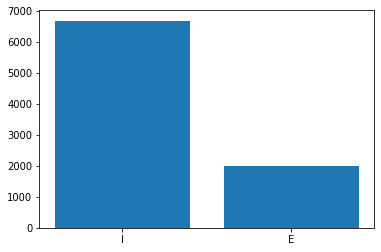

In [46]:
classes = data.types.unique()
counts = []

for i in classes:
  count = len(data[data.types==i])
  counts.append(count)

plt.bar(classes, counts)
plt.show()

In [48]:
data['cleaned_posts'] = data['posts'].apply(preprocessing)

LabelEncoder is used to encode the target labels into 0 and 1. Here label Extrovert('E') is encoded into '0' and Introvert is encoded as '1' 

In [49]:
from sklearn.preprocessing import LabelEncoder

labelencoder_IE = LabelEncoder()

data['Encoded_labels'] = labelencoder_IE.fit_transform(data['types'])
data

,types,posts,cleaned_posts,Encoded_labels
0,I,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank lifechanging ex...,1
1,E,'I'm finding the lack of me in these posts ver...,finding lack post alarming boring position oft...,0
2,I,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...,1
3,I,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation esoteric gabbing nat...,1
4,E,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,0
...,...,...,...,...
8670,I,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp always think cat doms reason especially w...,1
8671,E,'So...if this thread already exists someplace ...,soif thread already exists someplace else heck...,0
8672,I,'So many questions when i do these things. I ...,many question thing would take purple pill pic...,1
8673,I,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly m...,1


In [50]:
labelencoder_IE.classes_

array(['E', 'I'], dtype=object)

### **4.Splitting the dataset into training, validation and testing.**

The split ratio is 70% for training, remaining 30% is splitted between validation and test data.

In [51]:
data = data.sample(frac=1)

X = data['cleaned_posts']
y = data['Encoded_labels']


split_1 = int(0.7 * len(data))
split_2 = int(0.85 * len(data))

X_train1 = X[:split_1]
X_val1 = X[split_1:split_2]
X_test1 = X[split_2:]
y_train1 = y[:split_1]
y_val1 = y[split_1:split_2]
y_test1 = y[split_2:]
print("The shape of X_train : ",X_train1.shape)
print("The shape of y_train : ", y_train1.shape)
print("The shape of X_val : ",X_val1.shape)
print("The shape of y_val : ",y_val1.shape)
print("The shape of X_test : ",X_test1.shape)
print("The shape of y_test : ",y_test1.shape)

The shape of X_train :  (6072,)
The shape of y_train :  (6072,)
The shape of X_val :  (1301,)
The shape of y_val :  (1301,)
The shape of X_test :  (1302,)
The shape of y_test :  (1302,)


Converting the target class into binary matrix.

In [52]:
y_train1_BM = np_utils.to_categorical(y_train1)
y_val1_BM = np_utils.to_categorical(y_val1)
y_test1_BM = np_utils.to_categorical(y_test1)

 Choosing the BERT model used for this project. Here BERT SMALL is choosen. BERT has preprocessing and encoding layer. 

In [53]:
bert_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

Before sending the text inputs to BERT mpdel, the text should be transformed into numbers. The preprocessing layer encodes the text input into numeric token ids and arranged into several tensors. The preprocessing layer outputs 'input_word_ids', 'input_token_ids' and 'attension mask'. These are the inputs to the BERT model. 

The BERT encoder layer encodes these inputs and outputs the 'pooled_output', it represents the input sequence as a whole. 

BERT layers combined with the neural network layers gives the output. Sigmoid function is applied to the input and the outputs in the interval of (0, 1). 

In [54]:
num_class = len(labelencoder_IE.classes_)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='classifier')(output)
model = tf.keras.Model(text_input, output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

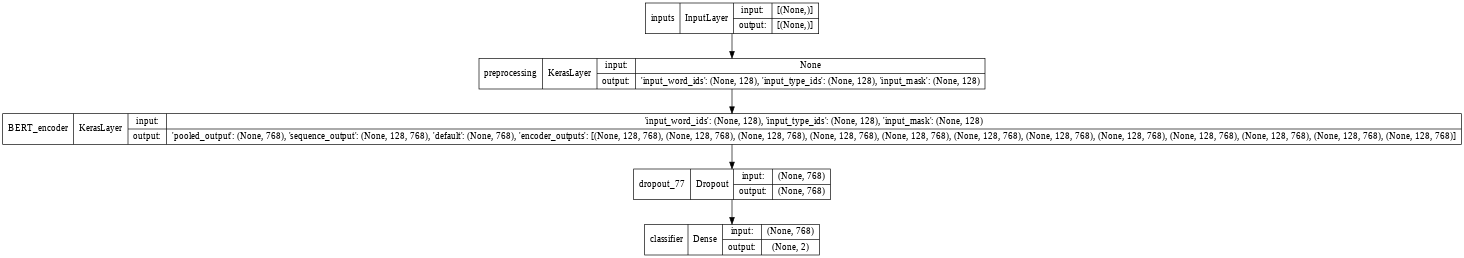

In [55]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Model's structure

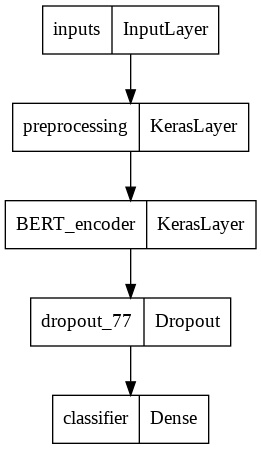

In [56]:
tf.keras.utils.plot_model(model)

BinaryCrossentropy() loss function was used.

For fine-turning, AdamW optimizer is used that minimizes the prediction loss and does regularization by weight decay.

In [58]:
epochs = 50
batch_size = 32 

train_data_size = len(y_train1_BM)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [59]:
loss = keras.losses.BinaryCrossentropy()
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
metrics=[auc, keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]

In [60]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [61]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [62]:
history = model.fit(
    X_train1, y_train1_BM,
    validation_data=(X_val1, y_val1_BM),
    epochs=epochs,
    batch_size=batch_size, callbacks = [earlystopping], verbose=2)

Epoch 1/50
190/190 - 382s - loss: 0.5982 - auc_2: 0.5012 - binary_accuracy: 0.7213 - precision_2: 0.7101 - recall_2: 0.7482 - val_loss: 0.5022 - val_auc_2: 0.5821 - val_binary_accuracy: 0.8002 - val_precision_2: 0.8002 - val_recall_2: 0.8002 - 382s/epoch - 2s/step
Epoch 2/50
190/190 - 353s - loss: 0.5592 - auc_2: 0.5324 - binary_accuracy: 0.7605 - precision_2: 0.7590 - recall_2: 0.7633 - val_loss: 0.4833 - val_auc_2: 0.6840 - val_binary_accuracy: 0.8005 - val_precision_2: 0.8003 - val_recall_2: 0.8009 - 353s/epoch - 2s/step
Epoch 3/50
190/190 - 360s - loss: 0.5202 - auc_2: 0.6595 - binary_accuracy: 0.7657 - precision_2: 0.7612 - recall_2: 0.7744 - val_loss: 0.4542 - val_auc_2: 0.7203 - val_binary_accuracy: 0.7971 - val_precision_2: 0.7953 - val_recall_2: 0.8002 - 360s/epoch - 2s/step
Epoch 4/50
190/190 - 346s - loss: 0.4799 - auc_2: 0.7420 - binary_accuracy: 0.7802 - precision_2: 0.7794 - recall_2: 0.7816 - val_loss: 0.4524 - val_auc_2: 0.7261 - val_binary_accuracy: 0.8040 - val_precis

In [63]:
loss1, auc1, accuracy1, precision1, recall1 = model.evaluate(X_test1, y_test1_BM, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy1)
print("Loss : ",loss1)
print("Precision : ",precision1)
print("Recall : ",recall1)
print("AUC : ", auc1)

Testing Accuracy:  0.7987711429595947
Loss :  0.48474153876304626
Precision :  0.7964938879013062
Recall :  0.8026113510131836
AUC :  0.7272381782531738


In [64]:
F1_IE = 2 * (precision1 * recall1) / (precision1 + recall1)
print("F1 score for Introvert/Extrovert(I/E): {:.4f}".format(F1_IE))

F1 score for Introvert/Extrovert(I/E): 0.7995


In [65]:
model.save("I-E_model1.h5")

In [66]:
!ls I-E_model1.h5

I-E_model1.h5


In [67]:
def plot_history(history):

  history_dict = history.history
  #print(history_dict.keys())

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(10, 6))


  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper left')
  plt.tight_layout()

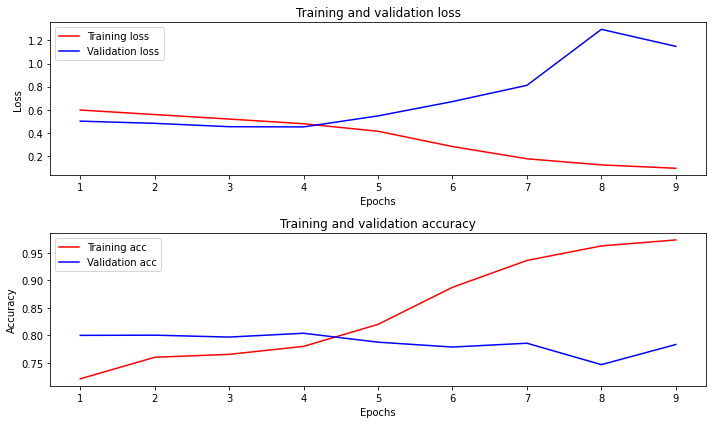

In [68]:
plot_history(history)

The above plot shows the Training loss and Validation loss and Training accuracy and Validation accuracy. It obvious that the model learns poorly and is overfitting as the validation loss keeps increasing and the validation accuracy stopped improving and starts declining after 5 epochs. This maybe due to the heavily immbalanced datasets.

In [69]:
predictions1 = model.predict(X_test1)

**Calculating the probability for ROC Curve**

In [ ]:
r_fpr, r_tpr, _ =  roc_curve(y_test1, r_probs)
m1_fpr, m1_tpr, _ = roc_curve(y_test1, y_predicted1)

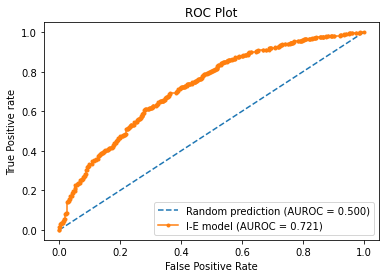

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m1_fpr, m1_tpr, marker='.', label = 'I-E model (AUROC = %.3f)'% roc_model1)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [70]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Introvert(I)' if labelencoder_IE.classes_[np.argmax(predict)]=='I' else 'MBTI type Extrovert(E)')

[[0.13 0.86]]
Input text is  MBTI type Introvert(I)


In [71]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Introvert(I)' if labelencoder_IE.classes_[np.argmax(predict)]=='I' else 'MBTI type Extrovert(E)')

[[0.16 0.86]]
Input text is  MBTI type Introvert(I)


In [72]:
reloaded_model_IE = tf.keras.models.load_model("I-E_model1.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

INFO:absl:gradient_clip_norm=1.000000


In [73]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = reloaded_model_IE.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Introvert(I)' if labelencoder_IE.classes_[np.argmax(predict)]=='I' else 'MBTI type Extrovert(E)')

[[0.13 0.86]]
Input text is  MBTI type Introvert(I)


In [74]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = reloaded_model_IE.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Introvert(I)' if labelencoder_IE.classes_[np.argmax(predict)]=='I' else 'MBTI type Extrovert(E)')

[[0.16 0.86]]
Input text is  MBTI type Introvert(I)


### **Loading the MBTI binary dataset with Sensing/INtuition type**

In [75]:
data2 = pd.read_csv("MBTI_BinaryLabels_N_S.csv")
data2.head()

,types,posts
0,N,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,N,'I'm finding the lack of me in these posts ver...
2,N,'Good one _____ https://www.youtube.com/wat...
3,N,"'Dear INTP, I enjoyed our conversation the o..."
4,N,'You're fired.|||That's another silly misconce...


In [76]:
data2['types'].value_counts()

N    7478
S    1197
Name: types, dtype: int64

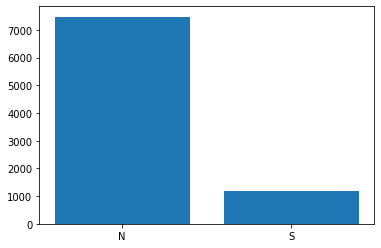

In [77]:
classes = data2.types.unique()
counts = []

for i in classes:
  count = len(data2[data2.types==i])
  counts.append(count)

plt.bar(classes, counts)
plt.show()

In [78]:
data2['cleaned_posts'] = data2['posts'].apply(preprocessing)

In [79]:
labelencoder_SN = LabelEncoder()

data2['Encoded_labels'] = labelencoder_SN.fit_transform(data2['types'])
data2

,types,posts,cleaned_posts,Encoded_labels
0,N,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank lifechanging ex...,0
1,N,'I'm finding the lack of me in these posts ver...,finding lack post alarming boring position oft...,0
2,N,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...,0
3,N,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation esoteric gabbing nat...,0
4,N,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,0
...,...,...,...,...
8670,S,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp always think cat doms reason especially w...,1
8671,N,'So...if this thread already exists someplace ...,soif thread already exists someplace else heck...,0
8672,N,'So many questions when i do these things. I ...,many question thing would take purple pill pic...,0
8673,N,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly m...,0


In [80]:
labelencoder_SN.classes_

array(['N', 'S'], dtype=object)

In [81]:
data2 = data2.sample(frac=1)
#print(binary_df1)

X = data2['cleaned_posts']
y = data2['Encoded_labels']


split_1 = int(0.7 * len(data2))
split_2 = int(0.85 * len(data2))

X_train2 = X[:split_1]
X_val2 = X[split_1:split_2]
X_test2 = X[split_2:]
y_train2 = y[:split_1]
y_val2 = y[split_1:split_2]
y_test2 = y[split_2:]
print("The shape of X_train : ",X_train2.shape)
print("The shape of y_train : ", y_train2.shape)
print("The shape of X_val : ",X_val2.shape)
print("The shape of y_val : ",y_val2.shape)
print("The shape of X_test : ",X_test2.shape)
print("The shape of y_test : ",y_test2.shape)

The shape of X_train :  (6072,)
The shape of y_train :  (6072,)
The shape of X_val :  (1301,)
The shape of y_val :  (1301,)
The shape of X_test :  (1302,)
The shape of y_test :  (1302,)


In [82]:
y_train2_BM = np_utils.to_categorical(y_train2)
y_val2_BM = np_utils.to_categorical(y_val2)
y_test2_BM = np_utils.to_categorical(y_test2)

In [83]:
num_class = len(labelencoder_SN.classes_)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='classifier')(output)
model = tf.keras.Model(text_input, output)
#model.summary()

In [84]:
epochs = 50
batch_size = 32  

train_data_size = len(y_train2_BM)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [85]:
loss = keras.losses.BinaryCrossentropy()
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
metrics=[auc, keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]

In [86]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [87]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [88]:
history = model.fit(
    X_train2, y_train2_BM,
    validation_data=(X_val2, y_val2_BM),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
190/190 - 366s - loss: 0.6303 - auc_3: 0.4966 - binary_accuracy: 0.6568 - precision_3: 0.6541 - recall_3: 0.6653 - val_loss: 0.3673 - val_auc_3: 0.5754 - val_binary_accuracy: 0.8782 - val_precision_3: 0.8785 - val_recall_3: 0.8778 - 366s/epoch - 2s/step
Epoch 2/50
190/190 - 344s - loss: 0.4071 - auc_3: 0.5470 - binary_accuracy: 0.8596 - precision_3: 0.8597 - recall_3: 0.8595 - val_loss: 0.3642 - val_auc_3: 0.6410 - val_binary_accuracy: 0.8786 - val_precision_3: 0.8786 - val_recall_3: 0.8786 - 344s/epoch - 2s/step
Epoch 3/50
190/190 - 343s - loss: 0.3887 - auc_3: 0.6585 - binary_accuracy: 0.8590 - precision_3: 0.8610 - recall_3: 0.8562 - val_loss: 0.3558 - val_auc_3: 0.6884 - val_binary_accuracy: 0.8766 - val_precision_3: 0.8781 - val_recall_3: 0.8747 - 343s/epoch - 2s/step
Epoch 4/50
190/190 - 344s - loss: 0.3522 - auc_3: 0.7596 - binary_accuracy: 0.8600 - precision_3: 0.8599 - recall_3: 0.8602 - val_loss: 0.3434 - val_auc_3: 0.7100 - val_binary_accuracy: 0.8778 - val_precis

In [89]:
loss2, auc2, accuracy2, precision2, recall2 = model.evaluate(X_test2, y_test2_BM, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy2)
print("Loss : ",loss2)
print("Precision : ",precision2)
print("Recall : ",recall2)
print("AUC score : ",auc2)

Testing Accuracy:  0.8598310351371765
Loss :  0.3601120412349701
Precision :  0.8584544658660889
Recall :  0.861751139163971
AUC score :  0.7399067878723145


In [90]:
F1_SN = 2 * (precision2 * recall2) / (precision2 + recall2)
print("F1 score for Sensing/INtuition(S/N): {:.4f}".format(F1_SN))

F1 score for Sensing/INtuition(S/N): 0.8601


In [91]:
model.save("S-N_model1.h5")

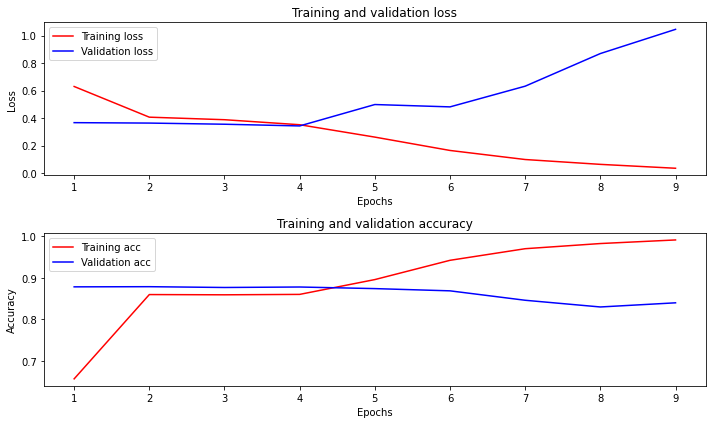

In [93]:
plot_history(history)

In [94]:
predictions2 = model.predict(X_test2)

In [ ]:
r_probs = [0 for _ in range(len(y_test2))]

r_auc = roc_auc_score(y_test2, r_probs)
roc_model2 = roc_auc_score(y_test2, y_predicted2)
print("Random (chance) prediction : AUROC = %.3f" % (r_auc))
print("SN_Model : AUROC = %.3f" % (roc_model2))

Random (chance) prediction : AUROC = 0.500
SN_Model : AUROC = 0.692


In [ ]:
r_fpr, r_tpr, _ =  roc_curve(y_test2, r_probs)
m2_fpr, m2_tpr, _ = roc_curve(y_test2, y_predicted2)

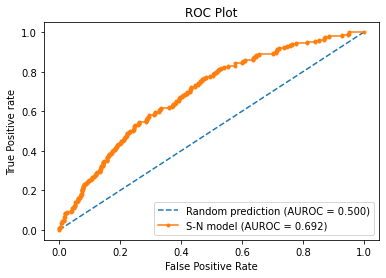

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m2_fpr, m2_tpr, marker='.', label = 'S-N model (AUROC = %.3f)'% roc_model2)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [95]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Sensing(S)' if labelencoder_SN.classes_[np.argmax(predict)]=='S' else 'MBTI type INtuition(N)')

[[0.31 0.66]]
Input text is  MBTI type Sensing(S)


In [96]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Sensing(S)' if labelencoder_SN.classes_[np.argmax(predict)]=='S' else 'MBTI type INtuition(N)')

[[0.25 0.66]]
Input text is  MBTI type Sensing(S)


In [97]:
reloaded_model_SN = tf.keras.models.load_model("S-N_model1.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

INFO:absl:gradient_clip_norm=1.000000


In [98]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = reloaded_model_SN.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Sensing(S)' if labelencoder_SN.classes_[np.argmax(predict)]=='S' else 'MBTI type INtuition(N)')

[[0.31 0.66]]
Input text is  MBTI type Sensing(S)


In [99]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = reloaded_model_SN.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Sensing(S)' if labelencoder_SN.classes_[np.argmax(predict)]=='S' else 'MBTI type INtuition(N)')

[[0.25 0.66]]
Input text is  MBTI type Sensing(S)


### **Loading the binary dataset with Feeling/Thinking type**

In [100]:
data3 = pd.read_csv("MBTI_BinaryLabels_F_T.csv")
data3.head()

,types,posts
0,F,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,T,'I'm finding the lack of me in these posts ver...
2,T,'Good one _____ https://www.youtube.com/wat...
3,T,"'Dear INTP, I enjoyed our conversation the o..."
4,T,'You're fired.|||That's another silly misconce...


In [101]:
data3['types'].value_counts()

F    4694
T    3981
Name: types, dtype: int64

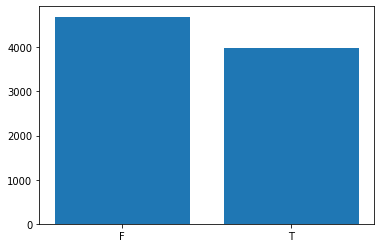

In [102]:
classes = data3.types.unique()
counts = []

for i in classes:
  count = len(data3[data3.types==i])
  counts.append(count)

plt.bar(classes, counts)
plt.show()

In [103]:
data3['cleaned_posts'] = data3['posts'].apply(preprocessing)

In [104]:
from sklearn.preprocessing import LabelEncoder

labelencoder_FT = LabelEncoder()

data3['Encoded_labels'] = labelencoder_FT.fit_transform(data3['types'])
data3

,types,posts,cleaned_posts,Encoded_labels
0,F,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank lifechanging ex...,0
1,T,'I'm finding the lack of me in these posts ver...,finding lack post alarming boring position oft...,1
2,T,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...,1
3,T,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation esoteric gabbing nat...,1
4,T,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,1
...,...,...,...,...
8670,F,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp always think cat doms reason especially w...,0
8671,F,'So...if this thread already exists someplace ...,soif thread already exists someplace else heck...,0
8672,T,'So many questions when i do these things. I ...,many question thing would take purple pill pic...,1
8673,F,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly m...,0


In [105]:
labelencoder_FT.classes_

array(['F', 'T'], dtype=object)

In [106]:
data3 = data3.sample(frac=1)

X = data3['cleaned_posts']
y = data3['Encoded_labels']


split_1 = int(0.7 * len(data3))
split_2 = int(0.85 * len(data3))

X_train3 = X[:split_1]
X_val3 = X[split_1:split_2]
X_test3 = X[split_2:]
y_train3 = y[:split_1]
y_val3 = y[split_1:split_2]
y_test3 = y[split_2:]
print("The shape of X_train : ",X_train3.shape)
print("The shape of y_train : ", y_train3.shape)
print("The shape of X_val : ",X_val3.shape)
print("The shape of y_val : ",y_val3.shape)
print("The shape of X_test : ",X_test3.shape)
print("The shape of y_test : ",y_test3.shape)

The shape of X_train :  (6072,)
The shape of y_train :  (6072,)
The shape of X_val :  (1301,)
The shape of y_val :  (1301,)
The shape of X_test :  (1302,)
The shape of y_test :  (1302,)


In [107]:
y_train3_BM = np_utils.to_categorical(y_train3)
y_val3_BM = np_utils.to_categorical(y_val3)
y_test3_BM = np_utils.to_categorical(y_test3)

In [108]:
num_class = len(labelencoder_FT.classes_)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='classifier')(output)
model = tf.keras.Model(text_input, output)

In [109]:
epochs = 50
batch_size = 8

train_data_size = len(y_train3_BM)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [110]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [111]:
history = model.fit(
    X_train3, y_train3_BM,
    validation_data=(X_val3, y_val3_BM),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
759/759 - 430s - loss: 0.6751 - auc_3: 0.6734 - binary_accuracy: 0.6199 - precision_3: 0.6222 - recall_3: 0.6107 - val_loss: 0.5998 - val_auc_3: 0.7510 - val_binary_accuracy: 0.6952 - val_precision_3: 0.7006 - val_recall_3: 0.6818 - 430s/epoch - 566ms/step
Epoch 2/50
759/759 - 406s - loss: 0.6102 - auc_3: 0.7324 - binary_accuracy: 0.6784 - precision_3: 0.6792 - recall_3: 0.6762 - val_loss: 0.5759 - val_auc_3: 0.8038 - val_binary_accuracy: 0.6968 - val_precision_3: 0.6951 - val_recall_3: 0.7010 - 406s/epoch - 535ms/step
Epoch 3/50
759/759 - 414s - loss: 0.5365 - auc_3: 0.8108 - binary_accuracy: 0.7407 - precision_3: 0.7441 - recall_3: 0.7337 - val_loss: 0.6018 - val_auc_3: 0.8074 - val_binary_accuracy: 0.7329 - val_precision_3: 0.7317 - val_recall_3: 0.7356 - 414s/epoch - 545ms/step
Epoch 4/50
759/759 - 414s - loss: 0.4477 - auc_3: 0.8792 - binary_accuracy: 0.8076 - precision_3: 0.8075 - recall_3: 0.8076 - val_loss: 0.6373 - val_auc_3: 0.7989 - val_binary_accuracy: 0.7114 - v

In [112]:
loss3, auc3, accuracy3, precision3, recall3 = model.evaluate(X_test3, y_test3_BM, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy3)
print("Loss : ",loss3)
print("Precision : ",precision3)
print("Recall : ",recall3)
print("AUC : ",auc3)

Testing Accuracy:  0.6916282773017883
Loss :  0.5883181691169739
Precision :  0.6900228261947632
Recall :  0.695852518081665
AUC :  0.7862252593040466


In [113]:
F1_FT = 2 * (precision3 * recall3) / (precision3 + recall3)
print("F1 score for Feeling/Thinking(F/T): {:.4f}".format(F1_FT))

F1 score for Feeling/Thinking(F/T): 0.6929


In [114]:
model.save("F-T_model1.h5")

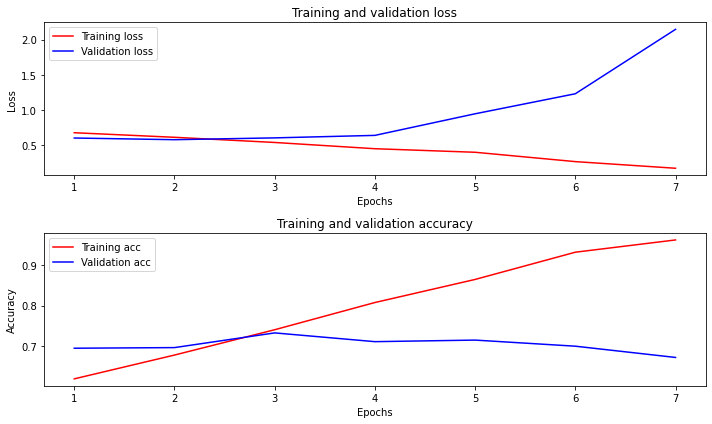

In [115]:
plot_history(history)

In [116]:
predictions3 = model.predict(X_test3)

In [ ]:
r_probs = [0 for _ in range(len(y_test3))]

r_auc = roc_auc_score(y_test3, r_probs)
roc_model3 = roc_auc_score(y_test3, y_predicted3)
print("Random (chance) prediction : AUROC = %.3f" % (r_auc))
print("FT_Model : AUROC = %.3f" % (roc_model3))

Random (chance) prediction : AUROC = 0.500
FT_Model : AUROC = 0.781


In [ ]:
r_fpr, r_tpr, _ =  roc_curve(y_test3, r_probs)
m3_fpr, m3_tpr, _ = roc_curve(y_test3, y_predicted3)

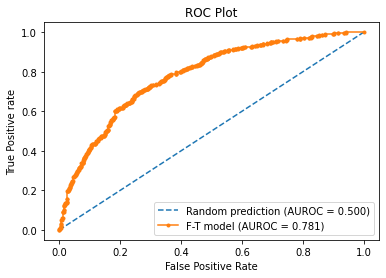

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m3_fpr, m3_tpr, marker='.', label = 'F-T model (AUROC = %.3f)'% roc_model3)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [117]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Feeling(F)' if labelencoder_FT.classes_[np.argmax(predict)]=='F' else 'MBTI type Thinking(T)')

[[0.38 0.29]]
Input text is  MBTI type Feeling(F)


In [118]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Feeling(F)' if labelencoder_FT.classes_[np.argmax(predict)]=='F' else 'MBTI type Thinking(T)')

[[0.5  0.41]]
Input text is  MBTI type Feeling(F)


In [119]:
reloaded_model_FT = tf.keras.models.load_model("F-T_model1.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

INFO:absl:gradient_clip_norm=1.000000


In [120]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = reloaded_model_FT.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Feeling(F)' if labelencoder_FT.classes_[np.argmax(predict)]=='F' else 'MBTI type Thinking(T)')

[[0.38 0.29]]
Input text is  MBTI type Feeling(F)


In [121]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = reloaded_model_FT.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Feeling(F)' if labelencoder_FT.classes_[np.argmax(predict)]=='F' else 'MBTI type Thinking(T)')

[[0.5  0.41]]
Input text is  MBTI type Feeling(F)


### **Loading the binary dataset with Judging/Perceiving type**

In [122]:
data4 = pd.read_csv("MBTI_BinaryLabels_J_P.csv")
data4

,types,posts
0,J,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,P,'I'm finding the lack of me in these posts ver...
2,P,'Good one _____ https://www.youtube.com/wat...
3,J,"'Dear INTP, I enjoyed our conversation the o..."
4,J,'You're fired.|||That's another silly misconce...
...,...,...
8670,P,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,P,'So...if this thread already exists someplace ...
8672,P,'So many questions when i do these things. I ...
8673,P,'I am very conflicted right now when it comes ...


In [123]:
data4['types'].value_counts()

P    5241
J    3434
Name: types, dtype: int64

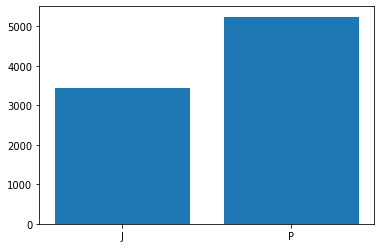

In [124]:
classes = data4.types.unique()
counts = []

for i in classes:
  count = len(data4[data4.types==i])
  counts.append(count)

plt.bar(classes, counts)
plt.show()

In [125]:
data4['cleaned_posts'] = data4['posts'].apply(preprocessing)

In [126]:
from sklearn.preprocessing import LabelEncoder

labelencoder_JP = LabelEncoder()

data4['Encoded_labels'] = labelencoder_JP.fit_transform(data4['types'])
data4

,types,posts,cleaned_posts,Encoded_labels
0,J,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank lifechanging ex...,0
1,P,'I'm finding the lack of me in these posts ver...,finding lack post alarming boring position oft...,1
2,P,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...,1
3,J,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation esoteric gabbing nat...,0
4,J,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,0
...,...,...,...,...
8670,P,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp always think cat doms reason especially w...,1
8671,P,'So...if this thread already exists someplace ...,soif thread already exists someplace else heck...,1
8672,P,'So many questions when i do these things. I ...,many question thing would take purple pill pic...,1
8673,P,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly m...,1


In [127]:
labelencoder_JP.classes_

array(['J', 'P'], dtype=object)

In [128]:
data4 = data4.sample(frac=1)
#print(binary_df1)

X = data4['cleaned_posts']
y = data4['Encoded_labels']


split_1 = int(0.7 * len(data4))
split_2 = int(0.85 * len(data4))

X_train4 = X[:split_1]
X_val4 = X[split_1:split_2]
X_test4 = X[split_2:]
y_train4 = y[:split_1]
y_val4 = y[split_1:split_2]
y_test4 = y[split_2:]
print("The shape of X_train : ",X_train4.shape)
print("The shape of y_train : ", y_train4.shape)
print("The shape of X_val : ",X_val4.shape)
print("The shape of y_val : ",y_val4.shape)
print("The shape of X_test : ",X_test4.shape)
print("The shape of y_test : ",y_test4.shape)

The shape of X_train :  (6072,)
The shape of y_train :  (6072,)
The shape of X_val :  (1301,)
The shape of y_val :  (1301,)
The shape of X_test :  (1302,)
The shape of y_test :  (1302,)


In [129]:
y_train4_BM = np_utils.to_categorical(y_train4)
y_val4_BM = np_utils.to_categorical(y_val4)
y_test4_BM = np_utils.to_categorical(y_test4)

In [130]:
num_class = len(labelencoder_JP.classes_)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='classifier')(output)
model = tf.keras.Model(text_input, output)

In [134]:
epochs = 50
batch_size = 8

train_data_size = len(y_train4_BM)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [135]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [136]:
history = model.fit(
    X_train4, y_train4_BM,
    validation_data=(X_val4, y_val4_BM),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
759/759 - 422s - loss: 0.6854 - auc_3: 0.5826 - binary_accuracy: 0.5984 - precision_3: 0.5908 - recall_3: 0.6402 - val_loss: 0.6616 - val_auc_3: 0.6098 - val_binary_accuracy: 0.6072 - val_precision_3: 0.6072 - val_recall_3: 0.6072 - 422s/epoch - 556ms/step
Epoch 2/50
759/759 - 403s - loss: 0.6472 - auc_3: 0.6321 - binary_accuracy: 0.6377 - precision_3: 0.6378 - recall_3: 0.6372 - val_loss: 0.6246 - val_auc_3: 0.6711 - val_binary_accuracy: 0.6580 - val_precision_3: 0.6539 - val_recall_3: 0.6710 - 403s/epoch - 531ms/step
Epoch 3/50
759/759 - 405s - loss: 0.6152 - auc_3: 0.6959 - binary_accuracy: 0.6635 - precision_3: 0.6622 - recall_3: 0.6673 - val_loss: 0.6210 - val_auc_3: 0.6775 - val_binary_accuracy: 0.6549 - val_precision_3: 0.6457 - val_recall_3: 0.6864 - 405s/epoch - 533ms/step
Epoch 4/50
759/759 - 403s - loss: 0.5500 - auc_3: 0.7824 - binary_accuracy: 0.7289 - precision_3: 0.7283 - recall_3: 0.7302 - val_loss: 0.7417 - val_auc_3: 0.6584 - val_binary_accuracy: 0.6683 - v

In [137]:
loss4, auc4, accuracy4, precision4, recall4 = model.evaluate(X_test4, y_test4_BM, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy4)
print("Loss : ",loss4)
print("Precision : ",precision4)
print("Recall : ",recall4)
print("AUC : ",auc4)

Testing Accuracy:  0.6666666865348816
Loss :  0.6211788058280945
Precision :  0.6565656661987305
Recall :  0.698924720287323
AUC :  0.6830830574035645


In [138]:
F1_JP = 2 * (precision4 * recall4) / (precision4 + recall4)
print("F1 score for Judging/Perceiving(J/P): {:.4f}".format(F1_JP))

F1 score for Judging/Perceiving(J/P): 0.6771


In [139]:
model.save("J-P_model1.h5")

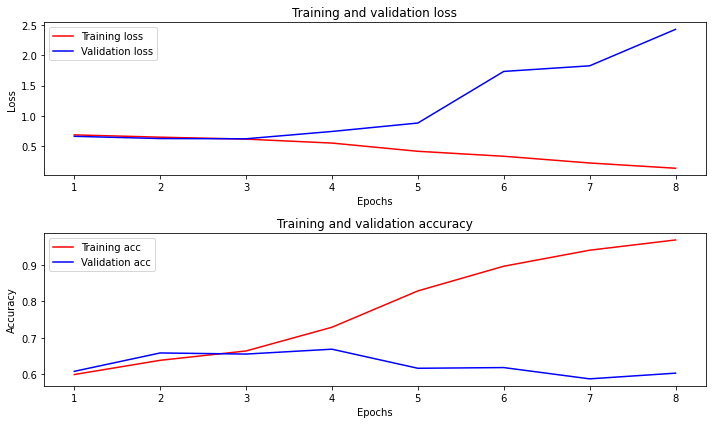

In [140]:
plot_history(history)

In [141]:
predictions4 = model.predict(X_test4)

In [ ]:
r_probs = [0 for _ in range(len(y_test4))]

r_auc = roc_auc_score(y_test4, r_probs)
roc_model4 = roc_auc_score(y_test4, y_predicted4)
print("Random (chance) prediction : AUROC = %.3f" % (r_auc))
print("JP_Model : AUROC = %.3f" % (roc_model4))

Random (chance) prediction : AUROC = 0.500
JP_Model : AUROC = 0.678


In [ ]:
r_fpr, r_tpr, _ =  roc_curve(y_test4, r_probs)
m4_fpr, m4_tpr, _ = roc_curve(y_test4, y_predicted4)

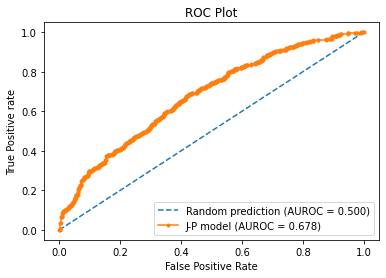

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m4_fpr, m4_tpr, marker='.', label = 'J-P model (AUROC = %.3f)'% roc_model4)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [142]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Perceiving(P)' if labelencoder_JP.classes_[np.argmax(predict)]=='P' else 'MBTI type Judging(J)')

[[0.35 0.66]]
Input text is  MBTI type Perceiving(P)


In [143]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Perceiving(P)' if labelencoder_JP.classes_[np.argmax(predict)]=='P' else 'MBTI type Judging(J)')

[[0.44 0.61]]
Input text is  MBTI type Perceiving(P)


In [144]:
reloaded_model_JP = tf.keras.models.load_model("J-P_model1.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

INFO:absl:gradient_clip_norm=1.000000


In [145]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = reloaded_model_JP.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Perceiving(P)' if labelencoder_JP.classes_[np.argmax(predict)]=='P' else 'MBTI type Judging(J)')

[[0.35 0.66]]
Input text is  MBTI type Perceiving(P)


In [146]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = reloaded_model_JP.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Perceiving(P)' if labelencoder_JP.classes_[np.argmax(predict)]=='P' else 'MBTI type Judging(J)')

[[0.44 0.61]]
Input text is  MBTI type Perceiving(P)


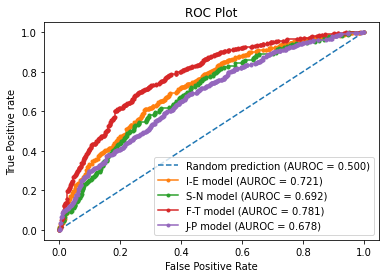

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m1_fpr, m1_tpr, marker='.', label = 'I-E model (AUROC = %.3f)'% roc_model1)
plt.plot(m2_fpr, m2_tpr, marker='.', label = 'S-N model (AUROC = %.3f)'% roc_model2)
plt.plot(m3_fpr, m3_tpr, marker='.', label = 'F-T model (AUROC = %.3f)'% roc_model3)
plt.plot(m4_fpr, m4_tpr, marker='.', label = 'J-P model (AUROC = %.3f)'% roc_model4)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [147]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict1 = reloaded_model_IE(sentences)
predict2 = reloaded_model_SN(sentences)
predict3 = reloaded_model_FT(sentences)
predict4 = reloaded_model_JP(sentences)

pred_types = []
scores = []
if labelencoder_IE.classes_[np.argmax(predict1)]=='I':
  pred_types.append('I')
  scores.append(predict1[0][1])
else:
  pred_types.append('E')
  scores.append(predict1[0][0])
if labelencoder_SN.classes_[np.argmax(predict2)]=='S':
  pred_types.append('S')
  scores.append(predict2[0][1])
else:
  pred_types.append('N')
  scores.append(predict2[0][0])
if labelencoder_FT.classes_[np.argmax(predict3)]=='T':
  pred_types.append('T')
  scores.append(predict3[0][1])
else:
  pred_types.append('F')
  scores.append(predict3[0][0])
if labelencoder_JP.classes_[np.argmax(predict4)]=='P':
  pred_types.append('P')
  scores.append(predict4[0][1])
else:
  pred_types.append('J')
  scores.append(predict4[0][0])
print('-- comment: ',sentences)
print('\n-- personality: ', pred_types)
print('\n-- scores:', scores)

-- comment:  ['I like studying deep learning, playing football and my guitar, and I love visit foreign cities all over the world.']

-- personality:  ['I', 'S', 'F', 'P']

-- scores: [<tf.Tensor: shape=(), dtype=float32, numpy=0.86014044>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6556573>, <tf.Tensor: shape=(), dtype=float32, numpy=0.37871265>, <tf.Tensor: shape=(), dtype=float32, numpy=0.65780985>]


In [148]:
models = ["I-E model", "S-N model", "F-T model", "J-P model"]
accuracy = []
precision = []
recall = []
F1_score = []
auc = []
accuracy.append(accuracy1)
accuracy.append(accuracy2)
accuracy.append(accuracy3)
accuracy.append(accuracy4)
precision.append(precision1)
precision.append(precision2)
precision.append(precision3)
precision.append(precision4)
recall.append(recall1)
recall.append(recall2)
recall.append(recall3)
recall.append(recall4)
F1_score.append(F1_IE)
F1_score.append(F1_SN)
F1_score.append(F1_FT)
F1_score.append(F1_JP)
auc.append(auc1)
auc.append(auc2)
auc.append(auc3)
auc.append(auc4)

evaluation_metrics = pd.DataFrame()

evaluation_metrics['Models'] = models
evaluation_metrics['Accuracy'] = accuracy
evaluation_metrics['Precision'] = precision
evaluation_metrics['Recall'] = recall
evaluation_metrics['F1 Score'] = F1_score
evaluation_metrics['AUC'] = auc

**The performance metrics of the four binary models combined in a dataframe**

In [149]:
evaluation_metrics

,Models,Accuracy,Precision,Recall,F1 Score,AUC
0,I-E model,0.798771,0.796494,0.802611,0.799541,0.727238
1,S-N model,0.859831,0.858454,0.861751,0.860100,0.739907
2,F-T model,0.691628,0.690023,0.695853,0.692925,0.786225
3,J-P model,0.666667,0.656566,0.698925,0.677083,0.683083
